![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [241]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV


# Import any additional modules and start coding below

data = pd.read_csv("rental_info.csv")
data.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [242]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [243]:
data.describe()

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
count,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000
mean,4.217161,2006.885379,2.944101,114.994578,20.224727,0.204842,0.200303,0.223378,0.198726,23.355504,14832.841876,11.389287
std,2.360383,2.025027,1.649766,40.114715,6.083784,0.403599,0.400239,0.416523,0.399054,23.503164,9393.431996,10.005293
min,0.990000,2004.000000,0.990000,46.000000,9.990000,0.000000,0.000000,0.000000,0.000000,0.980100,2116.000000,0.980100
25%,2.990000,2005.000000,0.990000,81.000000,14.990000,0.000000,0.000000,0.000000,0.000000,8.940100,6561.000000,0.980100
50%,3.990000,2007.000000,2.990000,114.000000,20.990000,0.000000,0.000000,0.000000,0.000000,15.920100,12996.000000,8.940100
75%,4.990000,2009.000000,4.990000,148.000000,25.990000,0.000000,0.000000,0.000000,0.000000,24.900100,21904.000000,24.900100
max,11.990000,2010.000000,4.990000,185.000000,29.990000,1.000000,1.000000,1.000000,1.000000,143.760100,34225.000000,24.900100


In [244]:
data.dtypes

rental_date          object
return_date          object
amount              float64
release_year        float64
rental_rate         float64
length              float64
replacement_cost    float64
special_features     object
NC-17                 int64
PG                    int64
PG-13                 int64
R                     int64
amount_2            float64
length_2            float64
rental_rate_2       float64
dtype: object

### Converting Rental Date and Return Date into DateTime 

In [245]:
data['return_date'] = pd.to_datetime(data['return_date'])

data['rental_date'] = pd.to_datetime(data['rental_date'])


In [246]:
data['rental_length_days'] = (data['return_date']-data['rental_date']).dt.days
data['rental_length_days']

0        3
1        2
2        7
3        2
4        4
        ..
15856    6
15857    4
15858    9
15859    8
15860    6
Name: rental_length_days, Length: 15861, dtype: int64

In [247]:
data.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4


In [248]:
data['special_features'].values

array(['{Trailers,"Behind the Scenes"}', '{Trailers,"Behind the Scenes"}',
       '{Trailers,"Behind the Scenes"}', ...,
       '{Trailers,"Deleted Scenes","Behind the Scenes"}',
       '{Trailers,"Deleted Scenes","Behind the Scenes"}',
       '{Trailers,"Deleted Scenes","Behind the Scenes"}'], dtype=object)

In [249]:
data['deleted_scenes'] = np.where(data['special_features'].str.contains('Deleted Scenes'), 1, 0)

In [250]:
data['behind_the_scenes'] = np.where(data['special_features'].str.contains('Behind the Scenes'), 1,0)

In [251]:
data.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4,0,1


In [252]:
features = ['amount', 'release_year', 'rental_rate', 'length', 
 'amount_2', 'length_2', 'rental_rate_2','replacement_cost', "deleted_scenes", "behind_the_scenes" , "NC-17", "PG", "PG-13", 'R' ]

X = data[features]
y = data["rental_length_days"]

In [253]:
SEED = 9
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = SEED)

### Decision Tree

In [254]:

dt= DecisionTreeRegressor()

dt.fit(X_train, y_train)
y_pred_proba =dt.predict(X_test)

mse = MSE(y_test, y_pred_proba)
print(mse)

2.173742692210259


### Ensemble Learning

In [255]:
logreg = LogisticRegression(random_state = SEED)
dt= DecisionTreeRegressor(random_state = SEED) 
rf = RandomForestRegressor(random_state = SEED)

regressors = {
    ('LogisticRegression' , logreg),
    ('DecisionTreeRegressor' , dt),
    ('RandomForestRegressor' , rf)   
}

for name, reg in regressors:
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print(f"{name} : {MSE(y_test, y_pred): .3f}")

LogisticRegression :  8.895
RandomForestRegressor :  2.029
DecisionTreeRegressor :  2.161


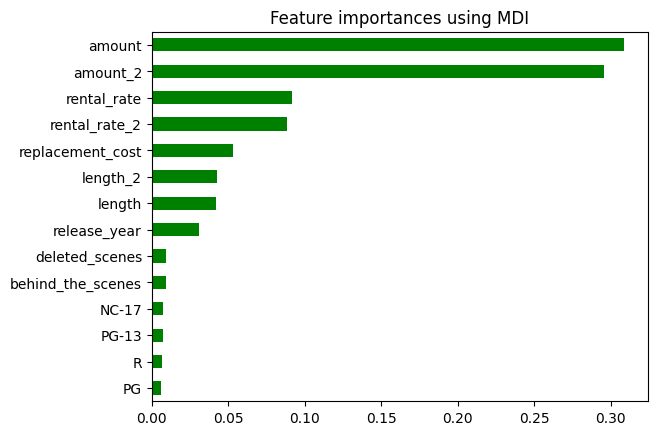

In [256]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index= X.columns).sort_values()

fig, ax= plt.subplots()
forest_importances.plot(kind = 'barh', color = 'Green')
ax.set_title("Feature importances using MDI")
plt.show()

In [257]:
params_dist = {
    'n_estimators' : np.arange(1,101,1),
    'max_depth' : np.arange(1,11,1)
}

In [258]:
rand_rf = RandomizedSearchCV(estimator=rf,
                       param_distributions=params_dist,
                       cv=5,
                       random_state = SEED)

In [259]:
rand_rf.fit(X_train, y_train)

hyper_params = rand_rf.best_params_

rf = RandomForestRegressor(n_estimators= hyper_params["n_estimators"],
                           max_depth= hyper_params["max_depth"], 
                           random_state =  SEED)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse_test = MSE(y_test, y_pred)

print('Test MSE of best model: {:.3f}'.format(mse_test)) 

Test MSE of best model: 2.226


In [260]:
best_model = rf
best_mse = mse_test

In [261]:
print(f"Best Model : {best_model}\nBest MSE: {best_mse}")

Best Model : RandomForestRegressor(max_depth=10, n_estimators=51, random_state=9)
Best MSE: 2.2263842817511676
